In [40]:
import draw_fig5, Query

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from collections import defaultdict
sns.set_style('ticks')
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
FPS = 8
_, auburn, _ = draw_fig5.get_auburn_queries()
auburn._load_persistence_value()
# auburn.privid_params.upper_bounds = [auburn.privid_params.upper_bounds]
_, hampton, _ = draw_fig5.get_hampton_queries()
hampton._load_persistence_value()
hampton.persistence = 120 * FPS
_, shibuya, _ = draw_fig5.get_shibuya_queries()
shibuya._load_persistence_value()
queries = {
    'Q1' : auburn,
    'Q2' : hampton,
    'Q3' : shibuya,
}

In [4]:
porto_queries = {
    'Q4' : {'rhos' : [45,195], 'range' : 16, 'secs_per_chunk' : 15, 'size' : 300}, 
    'Q5' : {'rhos' : [45,195], 'range' : 1, 'secs_per_chunk' : 15, 'size' : 1}
}

In [5]:
SECS_TO_HOURS = 1 / 60.0 / 60.0

# Figure 6

In [23]:
def hours_needed(T=0.05, p=0.99, eps=1, p_secs=[], output_ranges=[], secs_per_chunk=None, size=1):
    K=1
    rows = 0
    for rho in p_secs:
        rows += (math.ceil(rho / secs_per_chunk) + 1) * K
    delta = max(output_ranges) * rows / size
    b = delta / eps
    # window size (in chunks) needed to get T
    W = Query.linvcdf(p, 0, b) / T / sum(output_ranges)
    # print(f"rows={rows} ranges={output_ranges} delta={delta} b={b} W={W}")
    return W * (secs_per_chunk * SECS_TO_HOURS)

In [25]:
cols = defaultdict(list)
Es = np.logspace(0, -1.7, num=100) # [1.0, 0.5, 0.1, 0.05, 0.01]
Ts = [0.01]
ps = [0.95]
for T in Ts:
    for eps in Es:
        for p in ps:
            for name,q in queries.items():
                if not isinstance(q.privid_params.upper_bounds, list):
                    output_ranges = [q.privid_params.upper_bounds]
                else:
                    output_ranges = q.privid_params.upper_bounds
                hrs = hours_needed(
                    T=T,
                    p=p,
                    eps=eps,
                    p_secs = [q.persistence / FPS],
                    output_ranges = output_ranges,
                    secs_per_chunk = q.frames_per_chunk / FPS
                )
                cols['Query'].append(name)
                cols['T'].append(T)
                cols['p'].append(p)
                cols['# Queries'].append(1 / eps)
                cols['Hours Needed'].append(hrs)

data = pd.DataFrame(data=cols)

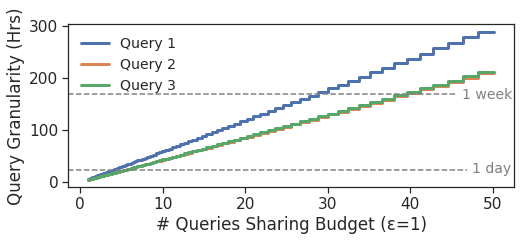

In [ ]:
sns.set(style='ticks', font_scale=1.4, rc={'figure.figsize' : (8,3)})

p = sns.lineplot(data=data, x="# Queries", y="Hours Needed", hue="Query", markers=True, dashes=False, linewidth=3, drawstyle="steps-pre")
p.set(
    xlabel="# Queries Sharing Budget (ε=1)",
    ylabel="Query Granularity (Hrs)",
)

p.axhline(y=24, color="gray", xmin=0, xmax=0.895, linestyle="--")
p.axhline(y=24*7, color="gray", xmin=0, xmax=0.87, linestyle="--")

p.annotate("1 day", xycoords="data", xy=(95/2,18), color="gray", fontsize="small")
p.annotate("1 week", xycoords="data", xy=(92.5/2,160), color="gray", fontsize="small")
p.annotate("1 month", xycoords="data", xy=(91/2,735), color="gray", fontsize="small")

plt.legend(loc="upper left", ncol=1, frameon=False, fontsize=14, labels=["Query 1", "Query 2", "Query 3"])
plt.savefig('num_queries_hours.pdf', dpi=300, bbox_inches="tight")

# Figure 7

In [37]:
def hours_needed_porto(T=0.05, p=0.99, eps=1, p_secs=[], output_ranges=[], secs_per_chunk=None, size=1, max_rows=1):
    K=1
    rows = 0
    for rho in p_secs:
        rows += (math.ceil(rho / secs_per_chunk) + 1) * K * max_rows
    # rows = (math.ceil(p_secs / secs_per_chunk) + 1) * K
    delta = max(output_ranges) * rows / (size * 365)
    b = delta / eps
    Query.linvcdf(p,0,b)
    # window size (in chunks) needed to get T
    W = Query.linvcdf(p, 0, b) / T / sum(output_ranges)
    # print(f"rows={rows} ranges={output_ranges} delta={delta} b={b} W={W}")
    return W * (secs_per_chunk * SECS_TO_HOURS)

In [38]:
def resulting_acc(eps=1, p_secs=[], output_ranges=[], secs_per_chunk=None, size=1, p=0.99, W=0):
    K=1
    rows = 0
    for rho in p_secs:
        rows += (math.ceil(rho / secs_per_chunk) + 1) * K
    # rows = (math.ceil(p_secs / secs_per_chunk) + 1) * K
    delta = max(output_ranges) * rows / size
    b = delta / eps
    T = Query.linvcdf(p, 0, b) / W / sum(output_ranges)
    return T

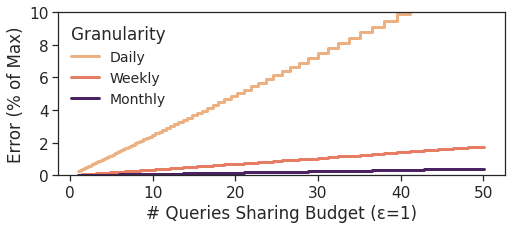

In [39]:
cols = defaultdict(list)
Es = np.logspace(0, -1.7, num=100) # [1.0, 0.5, 0.1, 0.05, 0.01]
# ps = [0.95]
p = 0.95
Ws = [24,24*7, 24*30]
for eps in Es:   
    for w in Ws:       
        for name,q in {'Q1' : queries['Q1']}.items():
            if not isinstance(q.privid_params.upper_bounds, list):
                output_ranges = [q.privid_params.upper_bounds]
            else:
                output_ranges = q.privid_params.upper_bounds
            err = resulting_acc(
                W=w * 60.0 * 60.0 / (q.frames_per_chunk / FPS),
                p=p,
                eps=eps,
                p_secs = [q.persistence / FPS],
                output_ranges = output_ranges,
                secs_per_chunk = q.frames_per_chunk / FPS)
            cols['Query'].append(name)
            cols['W'].append(w)
            cols['T'].append(err * 100)
            cols['p'].append(p)
            cols['# Queries'].append(1 / eps)

data = pd.DataFrame(data=cols)
sns.set(style='ticks', font_scale=1.4, rc={'figure.figsize' : (8,3)})

p = sns.lineplot(data=data, x="# Queries", y="T", hue="W", dashes=True, markers=False, linewidth=3, drawstyle="steps-pre", palette="flare")
p.set(
    xlabel="# Queries Sharing Budget (ε=1)",
    ylabel="Error (% of Max)",
    ylim=(0,10),
)

plt.legend(loc="upper left", ncol=1, frameon=False, fontsize=14, title="Granularity", labels=["Daily", "Weekly", "Monthly"])
plt.savefig('num_queries_err.pdf', dpi=300, bbox_inches="tight")